In [1]:
# Main imports
import numpy as np
import pandas as pd
import re

# Import matplotlib and such
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.ion()

from helper_functions import \
    thermodynamic_model, \
    plot_manifold_model, \
    plot_manifold_measurements, \
    get_measurement_subset_df
    

In [2]:
# Set global styles
textwidth=5.5
halfcolwidth=3
fontsize=8
titlesize=10
panel_label_size=12
legend_fontsize=7
markersize=5
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = False

# Get default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Used to create color gradient across data points of different P values
color_strong = np.array([.11, .69, .93])
color_weak = np.array([1.00, .94, .21])

# Conversion parameter
kbt_to_kcal = 1/1.62

# WT lac* sequence
wt_seq = 'CAGGCTTTACACCTGTTGCCTCCGGCTCGTATGTTGTGTGG'

In [3]:
# Now evaluate energy of all sites in list
def compute_energy(df, site):
    L = df.shape[0]
    assert matrix_df.shape[1] == 4, 'matrix has an invalid number of columns'
    assert all(df.columns == list('ACGT')), 'matrix has invalid columns'
    assert len(site)==L, 'site is the wrong length'
    assert set(site) <= set('ACGT'), 'site contains invalid bases'
    
    energy = 0
    for i, c in enumerate(site):
        energy += df.loc[i,c]
    return energy

In [4]:
# Load RNAP results table
tmp_df = pd.read_excel('../data/results.xlsx', sheet_name='rnap_summary')
tmp_df.head()

,location,rnap_site,spacing,dG_mean,dG_sem,ddG_matrix
0,b3C7,CAGGCTTTACACCTGTTGCCTCCGGCTCGTATGTTGTGTGG,-60.5,2.698659,0.033667,0.0000
1,b7D8,CAGGCTTTACACCTGTTGCCTCCGGCGCGTATGTTGTGTGG,-60.5,1.820122,0.033057,-0.3250
2,b7D9,CAGGCTTTACACCTGTTGCCTCCGGCTCGTATGTTTTGTGG,-60.5,3.393222,0.049117,0.1957
3,b7E1,CAGGCTTTACACCTGTTGCCTCCGGCTCGTACGTAGTGTGG,-60.5,5.297989,0.128820,1.5180
4,b7E2,CAGGCTTTACACCTGTTGCCTCCGGCTCGTATGTTGTGTGG,-60.5,2.929960,0.042702,0.0000


In [5]:
# Load RNAP PSAM matrix
matrix_df = pd.read_excel('../data/results.xlsx', sheet_name='rnap_motif')
del matrix_df['position']
matrix_df.head()

,A,C,G,T
0,0.0089,0.1109,0.0000,0.0963
1,0.0400,0.2615,0.0000,0.3227
2,0.0640,0.0240,0.0499,0.0000
3,0.0000,0.1247,0.0216,0.1117
4,0.5063,0.0463,0.0000,1.0121


In [6]:
spacings = list(set(tmp_df['spacing']))
spacings.sort()
spacings = spacings[::-1]
spacings

[-60.5,
 -61.5,
 -62.5,
 -63.5,
 -64.5,
 -65.5,
 -66.5,
 -71.5,
 -72.5,
 -76.5,
 -81.5,
 -82.5]

In [7]:
# Compute energy of wt sequence
wt_indices = [seq==wt_seq for seq in tmp_df['rnap_site']]
wt_dG = np.mean(tmp_df['dG_mean'][wt_indices])
wt_dG

3.05511888693376

Spacing -60.5: 21 points plotted.
Spacing -61.5: 44 points plotted.
Spacing -62.5: 23 points plotted.
Spacing -63.5: 20 points plotted.
Spacing -64.5: 17 points plotted.
Spacing -65.5: 17 points plotted.
Spacing -66.5: 16 points plotted.
Spacing -71.5: 35 points plotted.
Spacing -72.5: 19 points plotted.
Spacing -76.5: 16 points plotted.
Spacing -81.5: 32 points plotted.
Spacing -82.5: 19 points plotted.
Total: 279 points plotted.


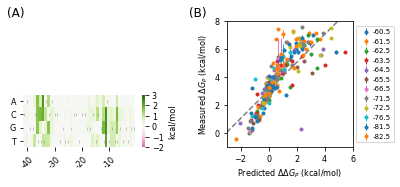

In [8]:
### Figure 5 ###

fig, ax = plt.subplots(1,1,figsize=[textwidth,2.5])
gs = gridspec.GridSpec(2, 2, top=.90, bottom=.20, left=.05, right=.90, hspace=.4, wspace=.4)

##### Panel A

## Display RNAP model ##
ax = plt.subplot(gs[1,0])

import seaborn as sns
    
# Plot matrix
sns.heatmap(data=matrix_df.T, ax=ax, cmap="PiYG", center=0, vmax=3, vmin=-2, cbar_kws={'label': 'kcal/mol'})

L = len(matrix_df)


# Plot dots
bases = 'ACGT'
for i, c in enumerate(wt_seq):
    j = bases.find(c)
    ax.plot(i+.5,j+.5,'|k', markersize=3, alpha=.2)

# Style plot
ax.set_xticks(np.arange(1,L,10)+.5)
ax.set_xticklabels(np.arange(-L+1,0,10), rotation=45)
ax.set_yticks(np.arange(4)+.5)
ax.set_yticklabels(list('ACGT'), rotation=0)
#ax.set_aspect(4)
sns.reset_orig()

##### Panel B

## Display scatter plot ##
ax = plt.subplot(gs[:,1])

# Compute lims
ylim = np.array([-1,8])
xlim = np.array([-3,6])

# Plot best-fit diagonal line
ax.plot(xlim, wt_dG+xlim, '--', color='gray')

# Get default color list
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

matrix_energies = tmp_df['ddG_matrix']
manifold_energies = tmp_df['dG_mean']
d_manifold_energies = tmp_df['dG_sem']
crp_centers = tmp_df['spacing']

total_points_plotted = 0
for n, spacing in enumerate(spacings):
        
    color = colors[n%len(colors)]
    spacing_str = '%.1f'%spacing
    indices = (crp_centers == spacing) & (d_manifold_energies < 1.62)

    # Plot data
    if sum(indices) > 0:
        ax.errorbar(matrix_energies[indices], manifold_energies[indices], d_manifold_energies[indices], 
                    marker='o', markersize=3, color=color, linestyle='none', elinewidth=1, label=spacing_str, 
                    alpha=1)
        total_points_plotted += sum(indices)

    print('Spacing %.1f: %d points plotted.'%(spacing,sum(indices)))

print('Total: %d points plotted.'%(total_points_plotted))
    
#ax.legend(handletextpad=0, fontsize=7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), handletextpad=0, fontsize=7)

# Style plot
ax.set_ylabel('Measured $\Delta G_P$ (kcal/mol)')
ax.set_yticks([0,2,4,6,8])
ax.set_xticks([-2,0,2,4,6])
ax.set_xlabel('Predicted $\Delta\Delta G_P$ (kcal/mol)')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_aspect('equal')

### Add panel labels
plt.figtext(.01,.98,'(A)', fontsize=panel_label_size, horizontalalignment='left', verticalalignment='top')
plt.figtext(.47,.98,'(B)', fontsize=panel_label_size, horizontalalignment='left', verticalalignment='top')

plt.savefig('../figures/plt_rnap_motif.pdf', transparent=True)